# Ungraded Lab: Generating Text from Irish Lyrics

In the previous lab, you trained a model on just a single song. You might have found that the output text can quickly become gibberish or repetitive. Even if you tweak the parameters, the model will still be limited by its vocabulary of only a few hundred words. The model will be more flexible if you train it on a much larger corpus and that's what you'll be doing in this lab. You will use lyrics from more Irish songs then see how the generated text looks like. You will also see how this impacts the process from data preparation to model training. Let's get started!

## Imports

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Building the Word Vocabulary

You will first download the lyrics dataset. These will be from a compilation of traditional Irish songs and you can see them [here](https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C3/W4/misc/Laurences_generated_poetry.txt).

In [2]:
# The dataset has already beed downloaded for you, so no need to run the following line of code.
# !wget https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt

Next, you will lowercase and split the plain text into a list of sentences:

In [6]:
# Load the dataset
data = open('./irish-lyrics-eof.txt').read()

# Lowercase and split the text
corpus = data.lower().split("\n")

# Preview the result
print(corpus[:10])

['come all ye maidens young and fair', 'and you that are blooming in your prime', 'always beware and keep your garden fair', 'let no man steal away your thyme', 'for thyme it is a precious thing', 'and thyme brings all things to my mind', 'nlyme with all its flavours, along with all its joys', 'thyme, brings all things to my mind', 'once i and a bunch of thyme', 'i thought it never would decay']


From here, you can initialize the `TextVectorization` class and generate the vocabulary:

In [7]:
# Initialize the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization()

# Build the vocabulary
vectorize_layer.adapt(corpus)

In [8]:
# Get the vocabulary and its size
vocabulary = vectorize_layer.get_vocabulary()
vocab_size = len(vocabulary)

print(f'{vocabulary[:10]}')
print(f'{vocab_size}')

['', '[UNK]', 'the', 'and', 'i', 'to', 'a', 'of', 'my', 'in']
2704


## Preprocessing the Dataset

Next, you will generate the inputs and labels for your model. The process will be identical to the previous lab. The `xs` or inputs to the model will be padded sequences, while the `ys` or labels are one-hot encoded arrays.

In [6]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:

	# Generate the integer sequence of the current line
	sequence = vectorize_layer(line).numpy()

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(sequence)):

		# Generate the subphrase
		n_gram_sequence = sequence[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences
input_sequences = np.array(tf.keras.utils.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)

You can then print some of the examples as a sanity check.

In [7]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence:
  token_list.append(vocabulary.index(word))

# Print the token list
print(token_list)

sample sentence: ['come', 'all', 'ye', 'maidens', 'young', 'and', 'fair']
[55, 13, 96, 1886, 49, 3, 71]


In [8]:
def sequence_to_text(sequence, vocabulary):
  '''utility to convert integer sequence back to text'''

  # Loop through the integer sequence and look up the word from the vocabulary
  words = [vocabulary[index] for index in sequence]

  # Combine the words into one sentence
  text = tf.strings.reduce_join(words, separator=' ').numpy().decode()

  return text

In [9]:
# Pick element
elem_number = 5

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {sequence_to_text(xs[elem_number], vocabulary)}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [   0    0    0    0    0    0    0    0    0   55   13   96 1886   49
    3]
decoded to text:          come all ye maidens young and
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 71


In [10]:
# Pick element
elem_number = 4

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {sequence_to_text(xs[elem_number], vocabulary)}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [   0    0    0    0    0    0    0    0    0    0   55   13   96 1886
   49]
decoded to text:           come all ye maidens young
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 3


Lastly, since this is a larger dataset, you can use the tf.data API to speed up the training.

In [11]:
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Put the inputs and labels to a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((xs,ys))

# Optimize the dataset for training
dataset = dataset.cache().prefetch(PREFETCH_BUFFER_SIZE).batch(BATCH_SIZE)

## Build and compile the Model

Next, you will build and compile the model. We placed some of the hyperparameters at the top of the code cell so you can easily tweak it later if you want.

In [12]:
# Parameters
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01

# Build the model
model = tf.keras.models.Sequential([
            tf.keras.Input(shape=(max_sequence_len-1,)),
            tf.keras.layers.Embedding(vocab_size, embedding_dim),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
            tf.keras.layers.Dense(vocab_size, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 15, 100)        │       270,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 300)            │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2704)           │       813,904 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,385,504 (5.29 MB)

 Trainable params: 1,385,504 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

From the model summary above, you'll notice that the number of trainable params is much larger than the one in the previous lab. Consequently, that usually means a slower training time. It will take roughly 7 seconds per epoch with the GPU enabled in Colab and you'll reach around 76% accuracy after 100 epochs.

In [13]:
epochs = 100

# Train the model
history = model.fit(dataset, epochs=epochs)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0608 - loss: 6.9267
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0834 - loss: 5.8908
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1025 - loss: 5.5136
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1259 - loss: 5.5474
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1371 - loss: 5.7076
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1622 - loss: 4.7368
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2201 - loss: 4.1609
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2683 - loss: 3.6509
Epoch 9/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3217 - loss: 3.1655
Epoch 10/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3758 - loss: 2.8301
Epoch 11/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4106 - loss: 2.5935
Epoch 12/100
375/375 ━━━━━━━━━━━━━━━━━━━━

You can visualize the accuracy below to see how it fluctuates as the training progresses.

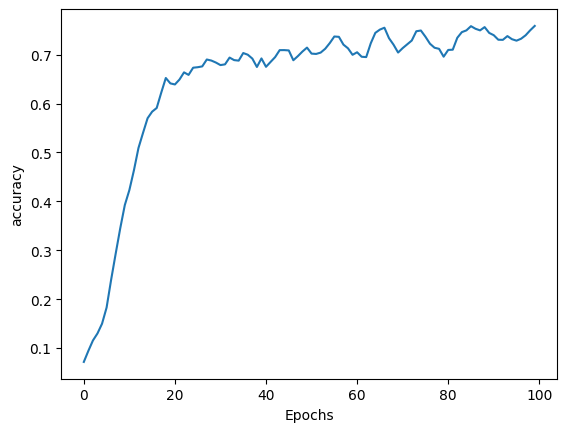

In [14]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

## Generating Text

Now you can let the model make its own songs or poetry! Because it is trained on a much larger corpus, the results below should contain less repetitions as before. The code below picks the next word based on the highest probability output.

In [15]:
# Define seed text
seed_text = "help me obi-wan kenobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Generate the integer sequence of the current line
	sequence = vectorize_layer(seed_text)

	# Pad the sequence
	sequence = tf.keras.utils.pad_sequences([sequence], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(sequence, verbose=0)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:

		# Look up the word associated with the index.
		output_word = vocabulary[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result
print(seed_text)

help me obi-wan kenobi youre my only hope by day will go from your hat ones right sash right love prove false i was lies between mary he hath any star rising above sharp away alone that tried travel away smile again tears in hand in danger until the color we were wed mary another hand away oer hill rah feet were bound turn water verdantly love forever wid the boyne and liffey from mythology together waves roll in bound dublin unseen born with gone and late only johnny dhu bride by corporal times away irish love forever by mountain valley far renownd of spancil hill grandmother cursing


Here again is the code that gets the top 3 predictions and picks one at random.

In [16]:
# Define seed text
seed_text = "help me obi-wan kenobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to an integer sequence
  sequence = vectorize_layer(seed_text)

	# Pad the sequence
  sequence = tf.keras.utils.pad_sequences([sequence], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(sequence, verbose=0)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])

  # Sort the probabilities in ascending order
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:

    # Look up the word associated with the index.
    output_word = vocabulary[predicted]

    # Combine with the seed text
    seed_text += " " + output_word

# Print the result
print(seed_text)

help me obi-wan kenobi youre my only hope by corporal times as day is desperate says quigley unto with pearse and i jeremy connolly jigs lies hill hill dow tree smile laughing in irish laughter and relations raising raising hill attend duram or asleep jeremy lanigan clung irishmen up gone the jeremy lanigan over in botany bay flag ranting before calling swiftly spotted sinking boatsman pains do verdantly jigs away til past hardship sustaining take dublin with clothes father wid ill clothes suits ten rostrevor nest suits raising nest smile a farthing and then late desperate bride leave oer morgan polkas love jeremy jigs oer the neagh feet


## Wrap Up

This lab shows the effect of having a larger dataset to train your text generation model. As expected, this will take a longer time to prepare and train but the output will less likely become repetitive or gibberish. Try to tweak the hyperparameters and see if you get better results. You can also find some other text datasets and use it to train the model here.  

In [17]:
# Shutdown the kernel to free up resources. 
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}